In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold

In [1]:
#/content/sample_data/SampleData_GasTurbines.csv

Predicting turbine energy yield (TEY) using ambient variables as features.

In [2]:
df = pd.read_csv('/content/sample_data/SampleData_GasTurbines.csv')

In [3]:
df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


In [19]:
df.corr()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
AT,1.000000,-0.609521,-0.137113,-0.148949,-0.214908,-0.028383,0.351544,-0.246415,-0.251172,-0.032751,-0.130674
AP,-0.609521,1.000000,-0.049414,0.291361,0.358212,0.247462,-0.403254,0.376773,0.399189,-0.051125,-0.091232
AH,-0.137113,-0.049414,1.000000,-0.092832,-0.325925,-0.244965,0.300565,-0.315373,-0.324431,0.076220,0.136425
AFDP,-0.148949,0.291361,-0.092832,1.000000,0.902537,0.711895,-0.771848,0.879910,0.884644,-0.299394,-0.748007
GTEP,-0.214908,0.358212,-0.325925,0.902537,1.000000,0.780855,-0.879973,0.986567,0.994707,-0.312531,-0.788748
TIT,-0.028383,0.247462,-0.244965,0.711895,0.780855,1.000000,-0.398431,0.853559,0.806147,-0.672935,-0.787929
TAT,0.351544,-0.403254,0.300565,-0.771848,-0.879973,-0.398431,1.000000,-0.813395,-0.861979,-0.061291,0.549030
TEY,-0.246415,0.376773,-0.315373,0.879910,0.986567,0.853559,-0.813395,1.000000,0.993107,-0.395917,-0.804273
CDP,-0.251172,0.399189,-0.324431,0.884644,0.994707,0.806147,-0.861979,0.993107,1.000000,-0.330594,-0.784955
CO,-0.032751,-0.051125,0.076220,-0.299394,-0.312531,-0.672935,-0.061291,-0.395917,-0.330594,1.000000,0.415542


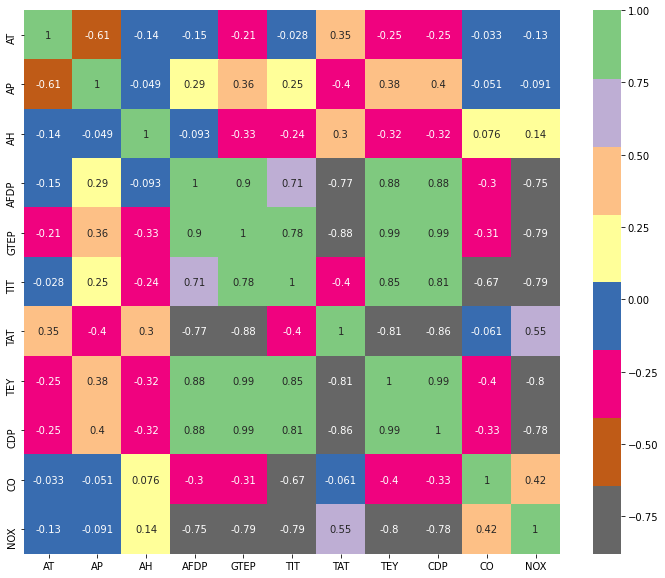

In [20]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),annot=True,cmap=plt.cm.Accent_r)

In [21]:
def correlation(dataset,threshold):
  col_corr=set()
  corr_matrix=dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range (i):
      if abs(corr_matrix.iloc[i,j])>threshold:
        colname=corr_matrix.columns[i]
        col_corr.add(colname)
  return col_corr

In [32]:
corr_features=correlation(X,0.65)

In [33]:
corr_features

{'CDP', 'CO', 'GTEP', 'NOX', 'TAT', 'TIT'}

In [34]:
#these are highly correlated values hence drop the features and move with only ambient features AT,AP,AH

In [35]:
df.shape

(600, 11)

In [36]:
df.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AT,600.0,7.698140,3.555552,0.917650,5.11435,7.33855,10.05275,18.925
AP,600.0,1014.177617,9.271578,987.840000,1009.35000,1015.00000,1021.50000,1029.100
AH,600.0,84.237157,10.438113,54.566000,77.77500,86.06400,91.69150,100.180
AFDP,600.0,4.719110,0.709280,3.459500,4.16385,4.41810,5.38495,6.358
GTEP,600.0,26.810733,4.682589,18.995000,23.77850,24.42150,32.43850,37.189
TIT,600.0,1087.166500,13.506195,1025.600000,1084.40000,1085.90000,1099.80000,1100.500
TAT,600.0,541.719633,10.926387,513.060000,528.81750,549.81000,550.03000,550.370
TEY,600.0,142.648267,16.051091,110.710000,133.73000,134.73000,161.18750,174.610
CDP,600.0,12.518967,1.167850,10.357000,11.80775,11.92000,13.94200,15.081
CO,600.0,2.192975,4.582324,0.022309,0.97331,1.44495,1.71600,44.103


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      600 non-null    float64
 1   AP      600 non-null    float64
 2   AH      600 non-null    float64
 3   AFDP    600 non-null    float64
 4   GTEP    600 non-null    float64
 5   TIT     600 non-null    float64
 6   TAT     600 non-null    float64
 7   TEY     600 non-null    float64
 8   CDP     600 non-null    float64
 9   CO      600 non-null    float64
 10  NOX     600 non-null    float64
dtypes: float64(11)
memory usage: 51.7 KB


**Outlier Check**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


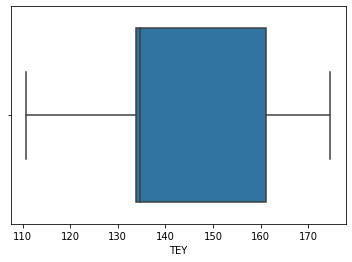

In [39]:
ax = sns.boxplot(df['TEY'])

Skew: 0.332321093021339
Kurtosis: -0.8901212781434249


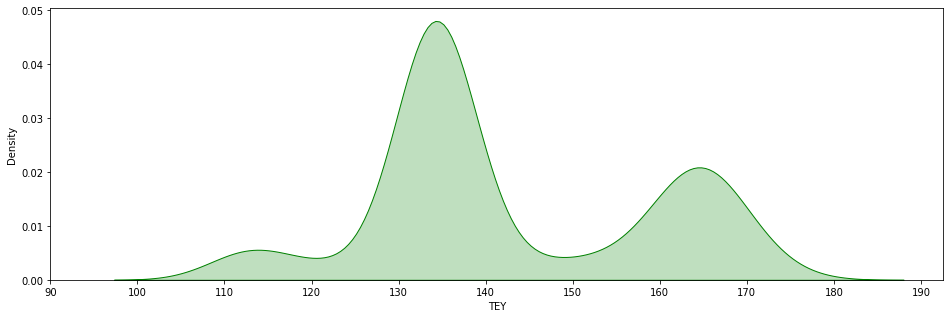

In [40]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(df['TEY'].skew()))
print("Kurtosis: {}".format(df['TEY'].kurtosis()))
ax = sns.kdeplot(df['TEY'],shade=True,color='g')
plt.xticks([i for i in range(90,200,10)])
plt.show()

The Data has no skewness and Majority of the TEY lies between 120 and 150

In [30]:
#Building Neural Network

In [82]:
X=df.drop(['CDP', 'CO', 'GTEP', 'NOX', 'TAT', 'TIT'],axis=1)
Y=df['TEY']

In [90]:
X.shape

(600, 5)

In [83]:
def norm_func(i):
    x = (i-i.min())/(i.max()-i.min())
    return (x)

In [84]:
X_norm = norm_func(X)

In [91]:
model = Sequential()
model.add(Dense(12, input_dim=5, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_145"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_388 (Dense)            (None, 12)                72        
_________________________________________________________________
dense_389 (Dense)            (None, 8)                 104       
_________________________________________________________________
dense_390 (Dense)            (None, 1)                 9         
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________


In [92]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [93]:
x_train,x_test,y_train,y_test= train_test_split(X_norm,Y, test_size=0.2)

In [94]:
>>> history = model.fit(x_train, y_train, epochs=100, batch_size=10)

Epoch 1/100
48/48 [==============================] - 0s 1ms/step - loss: 20598.5879 - mse: 20598.5879 - mae: 142.6439
Epoch 2/100
48/48 [==============================] - 0s 1ms/step - loss: 20380.3789 - mse: 20380.3789 - mae: 141.8868
Epoch 3/100
48/48 [==============================] - 0s 1ms/step - loss: 19915.5723 - mse: 19915.5723 - mae: 140.2576
Epoch 4/100
48/48 [==============================] - 0s 1ms/step - loss: 19072.3320 - mse: 19072.3320 - mae: 137.2547
Epoch 5/100
48/48 [==============================] - 0s 1ms/step - loss: 17742.7812 - mse: 17742.7812 - mae: 132.3804
Epoch 6/100
48/48 [==============================] - 0s 1ms/step - loss: 15878.7871 - mse: 15878.7871 - mae: 125.2118
Epoch 7/100
48/48 [==============================] - 0s 1ms/step - loss: 13527.6299 - mse: 13527.6299 - mae: 115.5309
Epoch 8/100
48/48 [==============================] - 0s 1ms/step - loss: 10818.6562 - mse: 10818.6553 - mae: 103.2844
Epoch 9/100
48/48 [==============================] - 0s 

In [95]:
y_pred=model.predict(x_test)

In [97]:
MSE= mean_squared_error(y_test, y_pred)
print('MSE: %f' % (MSE))

MSE: 57.249038


In [103]:
y_final=pd.DataFrame(data=y_test)

In [106]:
y_final['TEY_Predict']=y_pred

In [107]:
y_final

,TEY,TEY_Predict
340,174.40,168.685379
305,134.75,123.998306
321,111.71,96.944191
436,133.89,135.635818
519,112.91,102.029594
...,...,...
220,111.92,111.340919
27,134.24,135.212753
343,133.65,123.109695
150,134.73,135.080948
